In [ ]:
import numpy as np
import pandas as pd
from script.data_pipeline import shinyDataFetcher
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import itertools
import warnings

warnings.filterwarnings("ignore")

EV_stocks = ["TSLA", "RIVN", "LCID", "F", "GM", "NIO", "XPEV", "BYDDF", "LI"]
EV_stocks_data = {}
for stock in EV_stocks:
    EV_stocks_data[stock] = shinyDataFetcher(asset=stock, durationStr="3 Y", barSizeSetting="1 day").fetch_asset_data()

log_prices = {}
for ticker in EV_stocks:
    df_temp = EV_stocks_data[ticker].copy()
    df_temp["log_close"] = np.log(df_temp["close"])
    log_prices[ticker] = df_temp.set_index("timestamp")["log_close"].dropna()

# Loop over all unique pairs
for s1, s2 in itertools.combinations(EV_stocks, 2):
    # Align datasets by timestamp
    print(f"Processing pair: {s1} & {s2}")
    df_pair = pd.concat([log_prices[s1], log_prices[s2]], axis=1).dropna()
    if df_pair.empty:
        continue

    X = log_prices[s1]
    Y = log_prices[s2]
    X_const = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(Y, X_const).fit()
    print(f"OLS Coefficients: {model.params.to_dict()}, OLS p-value: {model.pvalues[1]:.4f}, OLS R-squared: {model.rsquared:.4f}")

    # Perform cointegration test
    result = coint(df_pair.iloc[:, 0], df_pair.iloc[:, 1])
    test_stat, p_value, crit_values = result

    print(f"Test Statistic: {test_stat:.3f}, p-value: {p_value:.4f}", f"Critical Values: {crit_values}")
    print(f"r-square > 0.5? {'Yes' if model.rsquared > 0.5 else 'No'}")
    print(f"Is cointegrated? {'Yes' if p_value < 0.05 else 'No'}")
    print("-" * 50)

Processing pair: TSLA & RIVN
OLS Coefficients: {'const': 1.2571776665748795, 'log_close': 0.2952130846949657}, OLS p-value: 0.0000, OLS R-squared: 0.0357
Test Statistic: -2.079, p-value: 0.4875 Critical Values: [-3.91112179 -3.34429984 -3.05011733]
r-square > 0.5? No
Is cointegrated? No
--------------------------------------------------
Processing pair: TSLA & LCID
OLS Coefficients: {'const': 2.038210342954358, 'log_close': -0.056926868044363615}, OLS p-value: 0.5626, OLS R-squared: 0.0004
Test Statistic: -2.675, p-value: 0.2087 Critical Values: [-3.91112179 -3.34429984 -3.05011733]
r-square > 0.5? No
Is cointegrated? No
--------------------------------------------------
Processing pair: TSLA & F
OLS Coefficients: {'const': 2.883557504363676, 'log_close': -0.07260837866851659}, OLS p-value: 0.0000, OLS R-squared: 0.0225
Test Statistic: -3.026, p-value: 0.1041 Critical Values: [-3.91112179 -3.34429984 -3.05011733]
r-square > 0.5? No
Is cointegrated? No
----------------------------------

In [5]:
fig = go.Figure()
asset_a = "TSLA"
asset_b = "RIVN"
fig.add_trace(go.Scatter(x=EV_stocks_data[asset_a]["timestamp"], y=np.log(EV_stocks_data[asset_a]["close"]), mode="lines", name=f"{asset_a}"))
fig.add_trace(go.Scatter(x=EV_stocks_data[asset_b]["timestamp"], y=np.log(EV_stocks_data[asset_b]["close"]), mode="lines", name=f"{asset_b}"))
fig.update_layout(title=f"{asset_a}  vs. {asset_b} Stock Log Prices", xaxis_title="timestamp", yaxis_title="Price (USD)", legend=dict(x=0, y=1))
fig.show()

In [7]:
X = np.log(EV_stocks_data[asset_a]["close"])
Y = np.log(EV_stocks_data[asset_b]["close"])
X_const = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(Y, X_const).fit()
print(model.summary())
import statsmodels.tsa.stattools as ts

result = ts.coint(X, Y)
print("Cointegration test result:")
print("========================================")
print("Test Statistic:", result[0])
print("p-value:", result[1])

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     27.73
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.82e-07
Time:                        22:14:32   Log-Likelihood:                -375.27
No. Observations:                 750   AIC:                             754.5
Df Residuals:                     748   BIC:                             763.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2572      0.305      4.120      0.0

In [11]:
def rolling_adf(spread_series, time_index, window=90):
    adf_stats = []
    p_values = []
    dates = []

    for i in range(window, len(spread_series)):
        window_data = spread_series.iloc[i - window : i]
        result = adfuller(window_data, maxlag=1, autolag=None)
        adf_stats.append(result[0])  # Test statistic
        p_values.append(result[1])  # p-value
        dates.append(time_index.iloc[i])
    return pd.DataFrame({"timestamp": dates, "adf_stat": adf_stats, "p_value": p_values})


trade_df = pd.merge(EV_stocks_data["RIVN"][["timestamp", "close"]], EV_stocks_data["TSLA"][["timestamp", "close"]], on="timestamp", suffixes=("_RIVN", "_TSLA"))
trade_df["log_close_TSLA"] = np.log(trade_df["close_TSLA"])
trade_df["log_close_RIVN"] = np.log(trade_df["close_RIVN"])
X = trade_df["log_close_TSLA"].astype(float)
Y = trade_df["log_close_RIVN"].astype(float)
X_with_const = sm.add_constant(X)
model = RollingOLS(endog=Y, exog=X_with_const, window=20)
rres = model.fit()
trade_df["hedge_ratio"] = rres.params["log_close_TSLA"]
trade_df["spread"] = trade_df["log_close_RIVN"] - trade_df["hedge_ratio"] * trade_df["log_close_TSLA"]
trade_df["z_score"] = (trade_df["spread"] - trade_df["spread"].rolling(window=20).mean()) / trade_df["spread"].rolling(window=20).std()
trade_df.dropna(inplace=True)
rolling_adf_df = rolling_adf(trade_df["spread"], trade_df["timestamp"], window=60)
trade_df = pd.merge(trade_df, rolling_adf_df, on="timestamp", how="left")
trade_df.dropna(inplace=True)

In [13]:
fig = go.Figure()
rolling_window = 60
fig.add_trace(go.Scatter(x=rolling_adf_df["timestamp"], y=rolling_adf_df["p_value"], mode="lines", name="Rolling ADF p-value"))
fig.add_hline(y=0.05, line_dash="dash", line_color="red", annotation_text="Significance threshold (0.05)", annotation_position="bottom right")
fig.update_layout(title=f"Rolling ADF Test on Spread (window={rolling_window})", xaxis_title="timestamp", yaxis_title="p-value")
fig.show()

In [ ]:
# Step-by-step trade logic
df = trade_df.copy()
df["position"] = 0  # 1: long spread, -1: short spread
df["trade_entry"] = False
df["trade_exit"] = False
df["pnl"] = 0.0

in_position = False
position_type = 0
entry_index = None
entry_spread = None

for i in range(len(df)):
    z = df["z_score"].iloc[i]
    spread = df["spread"].iloc[i]

    if not in_position:
        if z > 2:
            df.at[df.index[i], "position"] = -1
            df.at[df.index[i], "trade_entry"] = True
            in_position = True
            position_type = -1
            entry_index = i
            entry_spread = spread
        elif z < -2:
            df.at[df.index[i], "position"] = 1
            df.at[df.index[i], "trade_entry"] = True
            in_position = True
            position_type = 1
            entry_index = i
            entry_spread = spread
    else:
        stop_loss_triggered = (z > 3 and position_type == -1) or (z < -3 and position_type == 1)
        mean_reversion_triggered = abs(z) < 0.5
        timeout_triggered = i - entry_index >= 10

        if stop_loss_triggered or mean_reversion_triggered or timeout_triggered:
            df.at[df.index[i], "position"] = 0
            df.at[df.index[i], "trade_exit"] = True
            pnl = -(spread - entry_spread)
            df.at[df.index[i], "pnl"] = pnl
            in_position = False
            position_type = 0
            entry_index = None
            entry_spread = None
        else:
            df.at[df.index[i], "position"] = position_type

# Assuming 'df' is your DataFrame from the previous cell containing the computed spread, trade_entry, and trade_exit columns
spread_mean = df["spread"].mean()
spread_std = df["spread"].std()
fig = go.Figure()
# Plot the spread line
fig.add_trace(go.Scatter(x=df.index, y=df["spread"], mode="lines", name="Spread"))
# Plot horizontal lines: zero, ±2σ, and ±0.5σ
fig.add_trace(go.Scatter(x=[df.index[0], df.index[-1]], y=[0, 0], mode="lines", name="Zero Line", line=dict(dash="dash", color="black")))
fig.add_trace(go.Scatter(x=[df.index[0], df.index[-1]], y=[spread_mean + 2 * spread_std, spread_mean + 2 * spread_std], mode="lines", name="+2σ", line=dict(dash="dash", color="red")))
fig.add_trace(go.Scatter(x=[df.index[0], df.index[-1]], y=[spread_mean - 2 * spread_std, spread_mean - 2 * spread_std], mode="lines", name="-2σ", line=dict(dash="dash", color="red")))
fig.add_trace(go.Scatter(x=[df.index[0], df.index[-1]], y=[spread_mean + 0.5 * spread_std, spread_mean + 0.5 * spread_std], mode="lines", name="+0.5σ", line=dict(dash="dash", color="green")))
fig.add_trace(go.Scatter(x=[df.index[0], df.index[-1]], y=[spread_mean - 0.5 * spread_std, spread_mean - 0.5 * spread_std], mode="lines", name="-0.5σ", line=dict(dash="dash", color="green")))
# Scatter markers for trade entries and exits
entries_df = df[df["trade_entry"]]
exits_df = df[df["trade_exit"]]
fig.add_trace(go.Scatter(x=entries_df.index, y=entries_df["spread"], mode="markers", name="Entry", marker=dict(color="blue", size=10)))
fig.add_trace(go.Scatter(x=exits_df.index, y=exits_df["spread"], mode="markers", name="Exit", marker=dict(color="purple", size=10)))
fig.update_layout(title="Spread and Trade Entry/Exit Points", xaxis_title="Timestamp", yaxis_title="Spread", template="plotly_white")
fig.show()

In [ ]:
dd

,timestamp,close_RIVN,close_TSLA,log_close_TSLA,log_close_RIVN,hedge_ratio,spread,z_score,adf_stat,p_value,position,trade_entry,trade_exit,pnl,cumulative_pnl
60,2022-07-08,31.99,250.76,5.524496,3.465423,1.108226,-2.656969,-1.225487,-1.551199,0.508049,0,False,False,0.0,0.000000
61,2022-07-11,29.93,234.34,5.456773,3.398861,1.132528,-2.781088,-1.369341,-1.838264,0.361637,0,False,False,0.0,0.000000
62,2022-07-12,30.15,233.07,5.451339,3.406185,1.141880,-2.818590,-1.551397,-1.676010,0.443513,0,False,False,0.0,0.000000
63,2022-07-13,30.76,237.04,5.468229,3.426215,1.245694,-3.385527,-2.298003,-1.857733,0.352199,1,True,False,0.0,0.000000
64,2022-07-14,30.83,238.31,5.473572,3.428488,1.327210,-3.836090,-2.618729,-2.188877,0.210307,1,False,False,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2025-04-01,13.28,268.46,5.592702,2.586259,0.593491,-0.732960,-0.727309,-0.680060,0.851847,0,False,False,0.0,19.805438
746,2025-04-02,12.49,282.76,5.644598,2.524928,0.663671,-1.221229,-1.301616,-0.833207,0.809173,0,False,False,0.0,19.805438
747,2025-04-03,11.53,267.28,5.588297,2.444952,0.669680,-1.297417,-1.364838,-0.942913,0.773513,0,False,False,0.0,19.805438
748,2025-04-04,11.21,239.43,5.478261,2.416806,0.689992,-1.363151,-1.424663,-0.883840,0.793247,0,False,False,0.0,19.805438


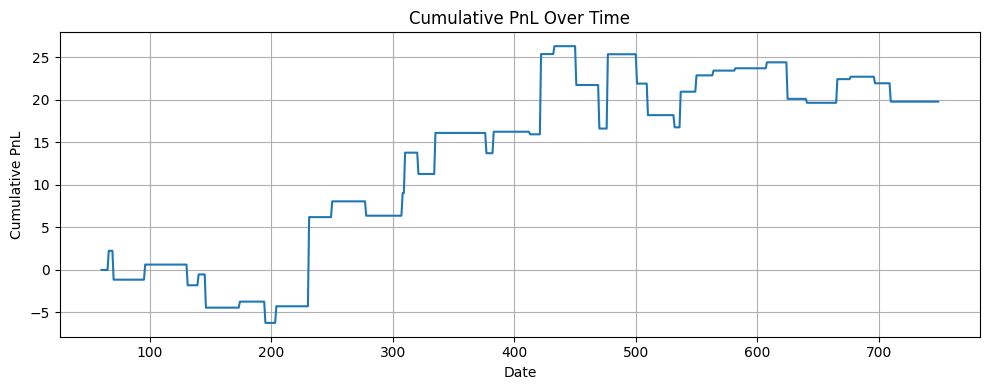

In [ ]:
# Create cumulative PnL column
df["cumulative_pnl"] = df["pnl"].cumsum()

# Trade summary metrics
total_trades = df["trade_exit"].sum()
total_pnl = df["pnl"].sum()
winning_trades = df[df["pnl"] > 0]["pnl"].count()
losing_trades = df[df["pnl"] < 0]["pnl"].count()
avg_return = df["pnl"][df["pnl"] != 0].mean()
win_rate = winning_trades / total_trades if total_trades > 0 else np.nan
entry_dates = df.loc[df["trade_entry"], "timestamp"].reset_index(drop=True)
exit_dates = df.loc[df["trade_exit"], "timestamp"].reset_index(drop=True)
holding_durations = [(exit_date - entry_date).days for entry_date, exit_date in zip(entry_dates, exit_dates)]
avg_holding_period = np.mean(holding_durations) if holding_durations else np.nan


# Summary dictionary
summary = {
    "Total Trades": total_trades,
    "Total PnL": round(total_pnl, 4),
    "Winning Trades": winning_trades,
    "Losing Trades": losing_trades,
    "Win Rate (%)": round(win_rate * 100, 2) if not np.isnan(win_rate) else "N/A",
    "Average Trade Return": round(avg_return, 4) if not np.isnan(avg_return) else "N/A",
    "Average Holding Period (days)": round(avg_holding_period, 2) if not np.isnan(avg_holding_period) else "N/A",
}

# Plot cumulative PnL
plt.figure(figsize=(10, 4))
df["cumulative_pnl"].plot(title="Cumulative PnL Over Time", grid=True)
plt.xlabel("Date")
plt.ylabel("Cumulative PnL")
plt.tight_layout()

In [ ]:
import pprint
pprint.pprint(summary)

{'Average Holding Period (days)': np.float64(9.26),
 'Average Trade Return': np.float64(0.5212),
 'Losing Trades': np.int64(17),
 'Total PnL': np.float64(19.8054),
 'Total Trades': np.int64(38),
 'Win Rate (%)': np.float64(55.26),
 'Winning Trades': np.int64(21)}
